# Assignment-10

### Import necessary libraries

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
from sklearn.preprocessing import MinMaxScaler
import base64
import copy
from keras.models import Sequential
from keras.layers import Dense
from math import log
from keras.layers import LSTM
from keras.layers import Dropout
import tensorflow as tf
tf.test.gpu_device_name()
device = '/device:GPU:0'

In [0]:
def splitTrainTest(data,percent):
    total=len(data)
    trainTotal=int(total*percent*0.01)
    testTotal=total-trainTotal
    return (data[0:trainTotal],data[trainTotal:total])

### Load dataset

In [15]:
data=pd.read_csv("GoogleStocks.csv").values[1:]
data=data[::-1]
av=(data[:,4:]).astype(np.float)
data[:,5]=av.mean(axis=1)
data=data[:,[3,2,5]]
print(data.shape)
# print(data)
# print(data)

(755, 3)


In [16]:
# 0 is open, 1 is volume, 2 is avg
sc = MinMaxScaler(feature_range = (0, 1))
scaledTrain = sc.fit_transform(data)
#80 20 split
scaledTrain,scaledTest=splitTrainTest(scaledTrain,80)
print(scaledTrain.shape,scaledTest.shape)

(604, 3) (151, 3)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


## Question-1

### Part-1: RNN

In [0]:
def trainRNN(hiddenLayers, cells, timeStep):
  print("===============================================================")
  print("Number of Hidden Layers: %d \nNumber of Cells: %d \nNumber of time Steps: %d"%(hiddenLayers, cells, timeStep))
  X_train = []
  y_train = []
  for i in range(timeStep, scaledTrain.shape[0]):
      X_train.append(scaledTrain[i-timeStep:i, [1,2]])#1 for volue 2 for average
      y_train.append(scaledTrain[i, 0])#0 for open stock price next day
  X_train, y_train = np.array(X_train), np.array(y_train)
  
#   print(X_train.shape)
  
  
  # Reshaping
  X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 2))# 2 input features
  print("Xtrain shape: %s with timestep: %d and features %d  "%(X_train.shape,timeStep,X_train.shape[2]))
  print("Ytrain shape ",y_train.shape)
  
  # Initialising the RNN
  regressor = Sequential()
  # Adding the first LSTM layer and some Dropout regularisation
  regressor.add(LSTM(units = cells, return_sequences = True, input_shape = (X_train.shape[1], 2)))
#   regressor.add(Dropout(0.2))

  for layer in range(hiddenLayers-1):
    # Adding a second LSTM layer and some Dropout regularisation
    if(layer==hiddenLayers-2):#last layer
      regressor.add(LSTM(units = cells))
#       regressor.add(Dropout(0.2))
    else:
      regressor.add(LSTM(units = cells, return_sequences = True))
#       regressor.add(Dropout(0.2))  
    
  # Adding the output layer
  regressor.add(Dense(units = 1))
  # Compiling the RNN
  regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

  # Fitting the RNN to the Training set
  regressor.fit(X_train, y_train, epochs = 100, batch_size =32,verbose=0)
  return regressor

In [0]:
def testRNN(timeStep,regressor):
  dataset_total=np.concatenate((scaledTrain,scaledTest),axis=0)
#   print(len(dataset_total),len(scaledTrain),len(scaledTest))

  inputs = dataset_total[len(dataset_total) - len(scaledTest) - timeStep:] #getting input of each previous financial days
#   print(inputs.shape)
  X_test = []
  y_test = scaledTest[:,0]#standardized value need to be inverse transform
#   print(inputs.shape)

  for i in range(timeStep, inputs.shape[0]):
      X_test.append(inputs[i-timeStep:i, [1,2]])
  
  X_test = np.array(X_test)
  X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 2))
  predicted_stock_price = regressor.predict(X_test)
  
  ######################## inverse tranform predicted y to original scale###############
  predicted_stock_price=predicted_stock_price.reshape(-1)
  trainPredict_extended = np.zeros((len(predicted_stock_price),3))
  # Put the predictions there
  trainPredict_extended[:,2] = predicted_stock_price
  # Inverse transform it and select the 3rd column.
  predicted_stock_price = sc.inverse_transform(trainPredict_extended)[:,2]
  ######################## inverse tranform predicted y to original scale###############
  
  ######################## inverse tranform actual y to original scale###############
  y_test=y_test.reshape(-1)
  y_test_extended = np.zeros((len(y_test),3))
  # Put the predictions there
  y_test_extended[:,2] = y_test
  # Inverse transform it and select the 3rd column.
  y_test = sc.inverse_transform(y_test_extended)[:,2]
  ######################## inverse tranform predicted y to original scale###############

#   print(predicted_stock_price.shape,len(y_test))
  return (y_test,predicted_stock_price)


In [0]:
def plotActualVspred(actual,predicted,hL, cells, tsteps):  
  plt.plot(actual, color = 'r', label = 'Actual Stock Price')
  plt.plot(predicted, color = 'b', label = 'Predicted Stock Price')
  plt.title('Stock Price Prediction (Hidden Layers=%d, cells=%d, Time step=%d)'%(hL,cells,tsteps))
  plt.xlabel('Time')
  plt.ylabel('Stock Price')
  plt.legend()
  plt.show()

Number of Hidden Layers: 2 
Number of Cells: 30 
Number of time Steps: 20
Xtrain shape: (584, 20, 2) with timestep: 20 and features 2  
Ytrain shape  (584,)


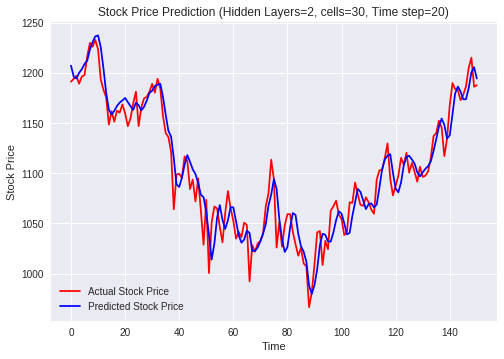

Number of Hidden Layers: 2 
Number of Cells: 30 
Number of time Steps: 50
Xtrain shape: (554, 50, 2) with timestep: 50 and features 2  
Ytrain shape  (554,)


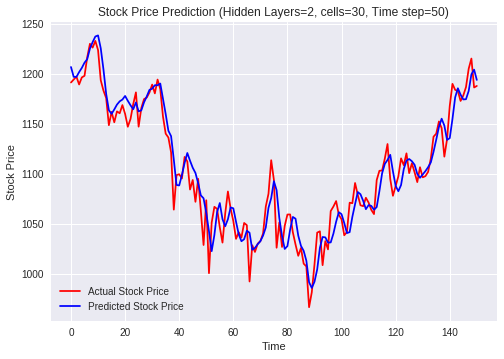

Number of Hidden Layers: 2 
Number of Cells: 30 
Number of time Steps: 75
Xtrain shape: (529, 75, 2) with timestep: 75 and features 2  
Ytrain shape  (529,)


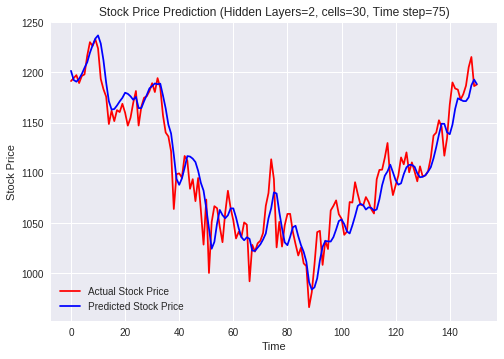

Number of Hidden Layers: 2 
Number of Cells: 50 
Number of time Steps: 20
Xtrain shape: (584, 20, 2) with timestep: 20 and features 2  
Ytrain shape  (584,)


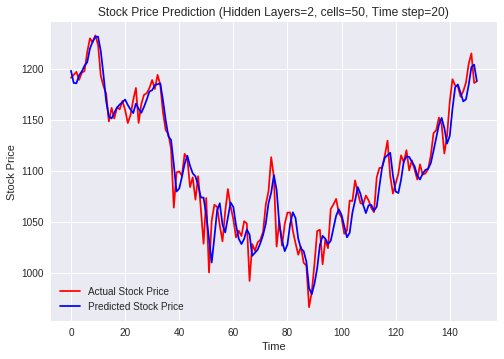

Number of Hidden Layers: 2 
Number of Cells: 50 
Number of time Steps: 50
Xtrain shape: (554, 50, 2) with timestep: 50 and features 2  
Ytrain shape  (554,)


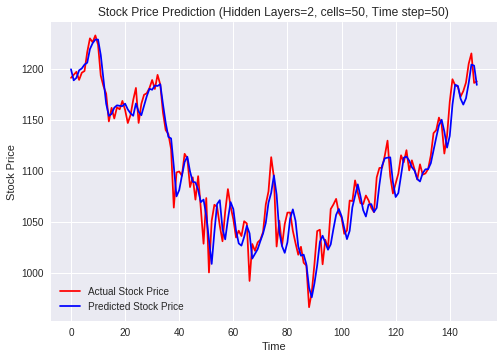

Number of Hidden Layers: 2 
Number of Cells: 50 
Number of time Steps: 75
Xtrain shape: (529, 75, 2) with timestep: 75 and features 2  
Ytrain shape  (529,)


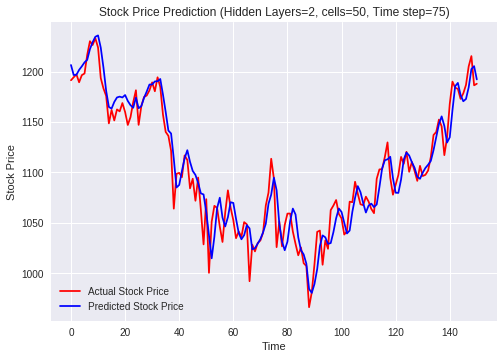

Number of Hidden Layers: 2 
Number of Cells: 80 
Number of time Steps: 20
Xtrain shape: (584, 20, 2) with timestep: 20 and features 2  
Ytrain shape  (584,)


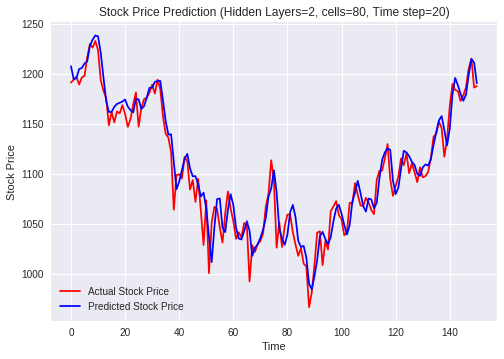

Number of Hidden Layers: 2 
Number of Cells: 80 
Number of time Steps: 50
Xtrain shape: (554, 50, 2) with timestep: 50 and features 2  
Ytrain shape  (554,)


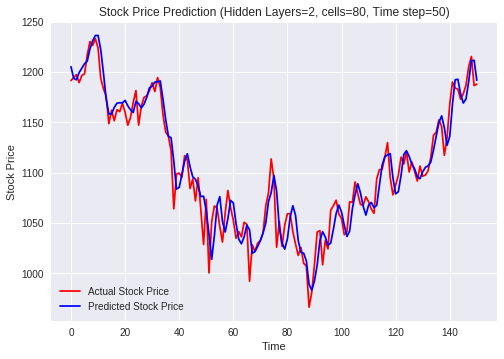

Number of Hidden Layers: 2 
Number of Cells: 80 
Number of time Steps: 75
Xtrain shape: (529, 75, 2) with timestep: 75 and features 2  
Ytrain shape  (529,)


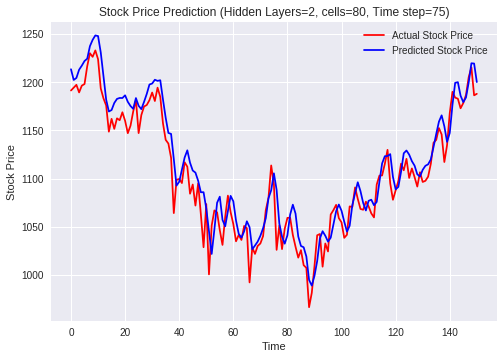

Number of Hidden Layers: 3 
Number of Cells: 30 
Number of time Steps: 20
Xtrain shape: (584, 20, 2) with timestep: 20 and features 2  
Ytrain shape  (584,)


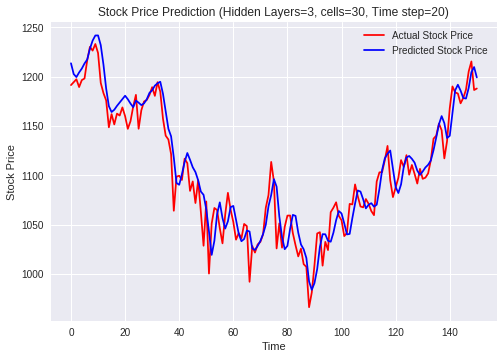

Number of Hidden Layers: 3 
Number of Cells: 30 
Number of time Steps: 50
Xtrain shape: (554, 50, 2) with timestep: 50 and features 2  
Ytrain shape  (554,)


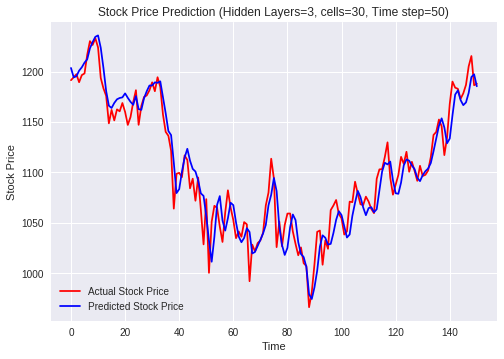

Number of Hidden Layers: 3 
Number of Cells: 30 
Number of time Steps: 75
Xtrain shape: (529, 75, 2) with timestep: 75 and features 2  
Ytrain shape  (529,)


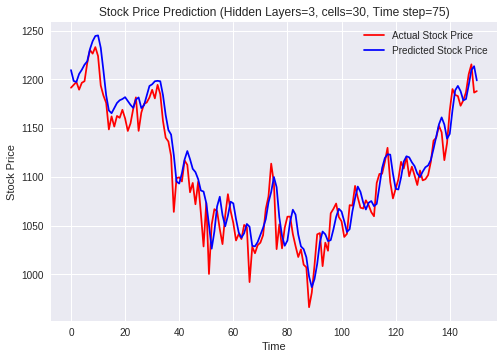

Number of Hidden Layers: 3 
Number of Cells: 50 
Number of time Steps: 20
Xtrain shape: (584, 20, 2) with timestep: 20 and features 2  
Ytrain shape  (584,)


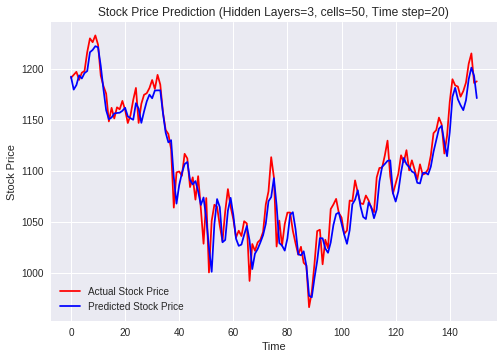

Number of Hidden Layers: 3 
Number of Cells: 50 
Number of time Steps: 50
Xtrain shape: (554, 50, 2) with timestep: 50 and features 2  
Ytrain shape  (554,)


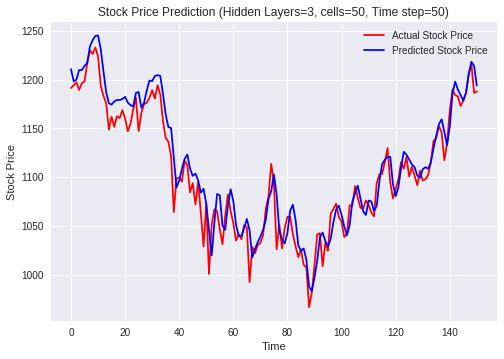

Number of Hidden Layers: 3 
Number of Cells: 50 
Number of time Steps: 75
Xtrain shape: (529, 75, 2) with timestep: 75 and features 2  
Ytrain shape  (529,)


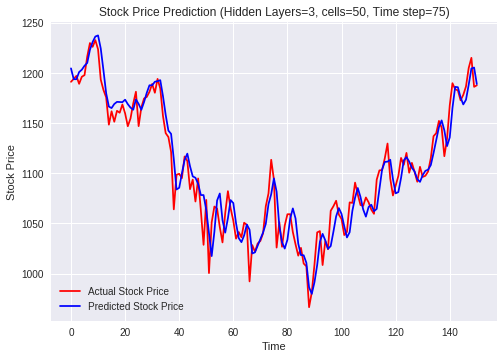

Number of Hidden Layers: 3 
Number of Cells: 80 
Number of time Steps: 20
Xtrain shape: (584, 20, 2) with timestep: 20 and features 2  
Ytrain shape  (584,)


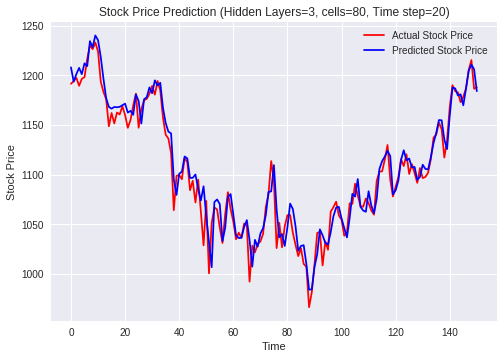

Number of Hidden Layers: 3 
Number of Cells: 80 
Number of time Steps: 50
Xtrain shape: (554, 50, 2) with timestep: 50 and features 2  
Ytrain shape  (554,)


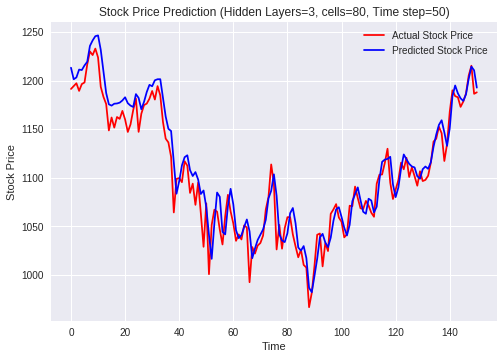

Number of Hidden Layers: 3 
Number of Cells: 80 
Number of time Steps: 75
Xtrain shape: (529, 75, 2) with timestep: 75 and features 2  
Ytrain shape  (529,)


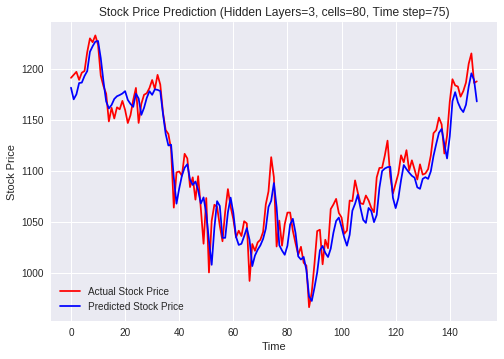

In [65]:
hLayers=[2,3]
cellss=[30,50,80]
tsteps=[20,50,75]
for hL in hLayers:
  for cell in cellss:
    for tstep in tsteps:
      model=trainRNN(hiddenLayers=hL,cells=cell,timeStep=tstep)
      actual,predicted=testRNN(timeStep=tstep,regressor=model)
      plotActualVspred(actual,predicted,hL,cell,tstep)      


### Part-2: HMM

## Question-2: DNA sequence

In [83]:
def DNA():
  observation_prob=[[0.25,0.25,0.25,0.25],[0.05,0,0.95,0],[0.4,0.1,0.1,0.4]]
  transition_prob=[[0.9,0.1,0],[0,0,1.0],[0,0,0.9]]
  sequence="CTTCATGTGAAAGCAGACGTAAGTCA"
  state_paths=["EEEEEEEEEEEEEEEEEE5IIIIIII","EEEEEE5IIIIIIIIIIIIIIIIIII","EEEEEEEE5IIIIIIIIIIIIIIIII","EEEEEEEEEEEEEEEEEEEEEE5III"]
  endProbT=0.1
  endProbOA=0.4
  symbols=['E','5','I']
  symboldict={}
  outputdict={'A':0,'C':1,'G':2,'T':3}
  for i,j in enumerate(symbols):
    symboldict[j]=i
  for state_path in state_paths:
    ans=0
    for i in range(len(sequence)-1):
      ans+=log(transition_prob[symboldict[state_path[i]]][symboldict[state_path[i+1]]])
      ans+=log(observation_prob[symboldict[state_path[i]]][outputdict[sequence[i]]])
    ans+=log(endProbT)+log(endProbOA)
    print("Probability of sequence: %s is %f "%(state_path,ans))
DNA()
  
  

Probability of sequence: EEEEEEEEEEEEEEEEEE5IIIIIII is -41.219678 
Probability of sequence: EEEEEE5IIIIIIIIIIIIIIIIIII is -43.897400 
Probability of sequence: EEEEEEEE5IIIIIIIIIIIIIIIII is -43.451113 
Probability of sequence: EEEEEEEEEEEEEEEEEEEEEE5III is -41.713398 
